# 13. Experimentation: The ensembling of the models

In [1]:
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.optim as optim
import torchvision
from torchvision import datasets, models
from torchvision import transforms as T
from torch.utils.data import DataLoader, Dataset
import numpy as np
import matplotlib.pyplot as plt
import os
import time
import pandas as pd
from skimage import io, transform
import matplotlib.image as mpimg
from PIL import Image
from sklearn.metrics import roc_auc_score
import torch.nn.functional as F
import scipy
import random
import pickle
import scipy.io as sio
import itertools
from scipy.ndimage.interpolation import shift
import copy
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline
plt.ion()

# Import Dataloader Class and other utilities

In [2]:
from dataloader_2d import *
from dataloader_3d import *

# Build Data loader objects

In [3]:
train_path = '/beegfs/ark576/new_knee_data/train'
val_path = '/beegfs/ark576/new_knee_data/val'
test_path = '/beegfs/ark576/new_knee_data/test'

train_file_names = sorted(pickle.load(open(train_path + '/train_file_names.p','rb')))
val_file_names = sorted(pickle.load(open(val_path + '/val_file_names.p','rb')))
test_file_names = sorted(pickle.load(open(test_path + '/test_file_names.p','rb')))

transformed_dataset = {'train': KneeMRIDataset(train_path,train_file_names, train_data= True, flipping=False, normalize= True),
                       'validate': KneeMRIDataset(val_path,val_file_names, normalize= True),
                       'test': KneeMRIDataset(test_path,test_file_names, normalize= True)
                                          }

dataloader = {x: DataLoader(transformed_dataset[x], batch_size=5,
                        shuffle=True, num_workers=0) for x in ['train', 'validate','test']}
data_sizes ={x: len(transformed_dataset[x]) for x in ['train', 'validate','test']}

In [4]:
im, seg_F, seg_P, seg_T,_ = next(iter(dataloader['train']))

# Find Max and min values of Images (all 7 contrasts), of Fractional Anisotropy maps and of Mean Diffusivity maps for image normalization

In [5]:
min_fa = np.inf
min_md = np.inf
min_image = np.inf
max_fa = 0
max_md = 0
max_image = 0
for data in dataloader['train']:
    if min_fa > torch.min(data[0][:,7,:,:]):
        min_fa = torch.min(data[0][:,7,:,:])
    if min_md > torch.min(data[0][:,8,:,:]):
        min_md = torch.min(data[0][:,8:,:])
    if min_image > torch.min(data[0][:,:7,:,:]):
        min_image = torch.min(data[0][:,:7,:,:])
    if max_fa < torch.max(data[0][:,7,:,:]):
        max_fa = torch.max(data[0][:,7,:,:])
    if max_md < torch.max(data[0][:,8,:,:]):
        max_md = torch.max(data[0][:,8,:,:])
    if max_image < torch.max(data[0][:,:7,:,:]):
        max_image = torch.max(data[0][:,:7,:,:])
norm_values = (max_image, min_image, max_fa, min_fa, max_md, min_md)

# Import Models

In [6]:
from unet_3d import *
from unet_basic_dilated import *
from vnet import *
from ensemble_model import *

In [7]:
seg_sum = torch.zeros(3)
for i, data in enumerate(dataloader['train']):
    input, segF, segP, segT,_ = data
    seg_sum[0] += torch.sum(segF)
    seg_sum[1] += torch.sum(segP)
    seg_sum[2] += torch.sum(segT)
mean_s_sum = seg_sum/i

## Import Loss functions and all other utility functions like functions for saving models, for visualizing images, etc.

In [8]:
from utils import *

## Import all the Training and evaluate functions to evaluate the models

In [10]:
from train_2d import *
from train_3d import *
from train_ensemble import *
from evaluate_2d import *
from evaluate_3d import *
from evaluate_ensemble import *

# 13. Experimentation: The ensembling of the models

In [410]:
ppnet = PPnet(8,4).cuda()

## Loading Two models that needs to be ensembled

In [36]:
model_1 = torch.load('new_data_unet_exp_1')
model_2 = torch.load('new_data_dilated_smaller_3')
pred_models = [model_1,model_2]

In [437]:
optimizer_pp = optim.Adam(ppnet.parameters(),lr = 5e-5)

In [ ]:
ppnet, loss_hist_pp, dc_hist_0_pp, \
dc_hist_1_pp, dc_hist_2_pp = train_pp_model(ppnet, pred_models, optimizer_pp,
                                                     dataloader,data_sizes,5,'new_data_ppnet_2',
                                                     num_epochs=30, verbose = True, 
                                                     dice_loss = dice_loss_3)

Epoch: 0, Phase: train, epoch loss: 0.3477, Dice Score (class 0): 0.6932, Dice Score (class 1): 0.8265,Dice Score (class 2): 0.7680
----------
Epoch: 0, Phase: validate, epoch loss: 0.4218, Dice Score (class 0): 0.6892, Dice Score (class 1): 0.7804,Dice Score (class 2): 0.6037
----------
Epoch: 1, Phase: train, epoch loss: 0.3465, Dice Score (class 0): 0.6933, Dice Score (class 1): 0.8169,Dice Score (class 2): 0.7583
----------
Epoch: 1, Phase: validate, epoch loss: 0.4209, Dice Score (class 0): 0.6894, Dice Score (class 1): 0.7839,Dice Score (class 2): 0.6065
----------
Epoch: 2, Phase: train, epoch loss: 0.3486, Dice Score (class 0): 0.6977, Dice Score (class 1): 0.8189,Dice Score (class 2): 0.7616
----------
Epoch: 2, Phase: validate, epoch loss: 0.4268, Dice Score (class 0): 0.6889, Dice Score (class 1): 0.7774,Dice Score (class 2): 0.6066
----------
Epoch: 3, Phase: train, epoch loss: 0.3457, Dice Score (class 0): 0.6945, Dice Score (class 1): 0.8186,Dice Score (class 2): 0.7626
-

In [ ]:
# torch.save(model_gen_dilated_l4_n2_new_data_dp,'new_data_dilated_net_l4_n2_nd_dp_1')
pickle.dump(loss_hist_pp, open('loss_hist_new_data_ppnet_2','wb'))
pickle.dump(dc_hist_0_pp, open('dc_hist_0_new_data_ppnet_2','wb'))
pickle.dump(dc_hist_1_pp, open('dc_hist_1_new_data_ppnet_2','wb'))
pickle.dump(dc_hist_2_pp, open('dc_hist_2_new_data_ppnet_2','wb'))

In [ ]:
plot_hist(loss_hist_pp,'Loss')

In [ ]:
evaluate(ppnet, pred_models, dataloader, data_sizes, 5, 'validate', dice_loss=dice_loss_3)

In [37]:
loaded_model = torch.load('new_data_ppnet_2')

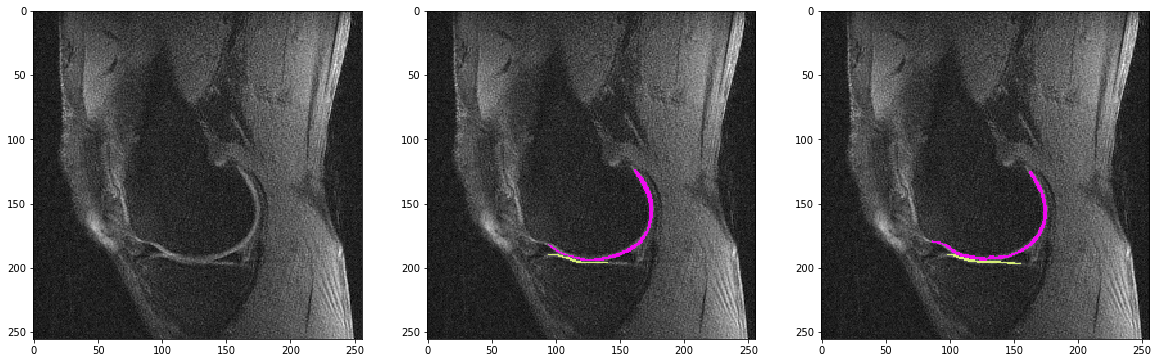

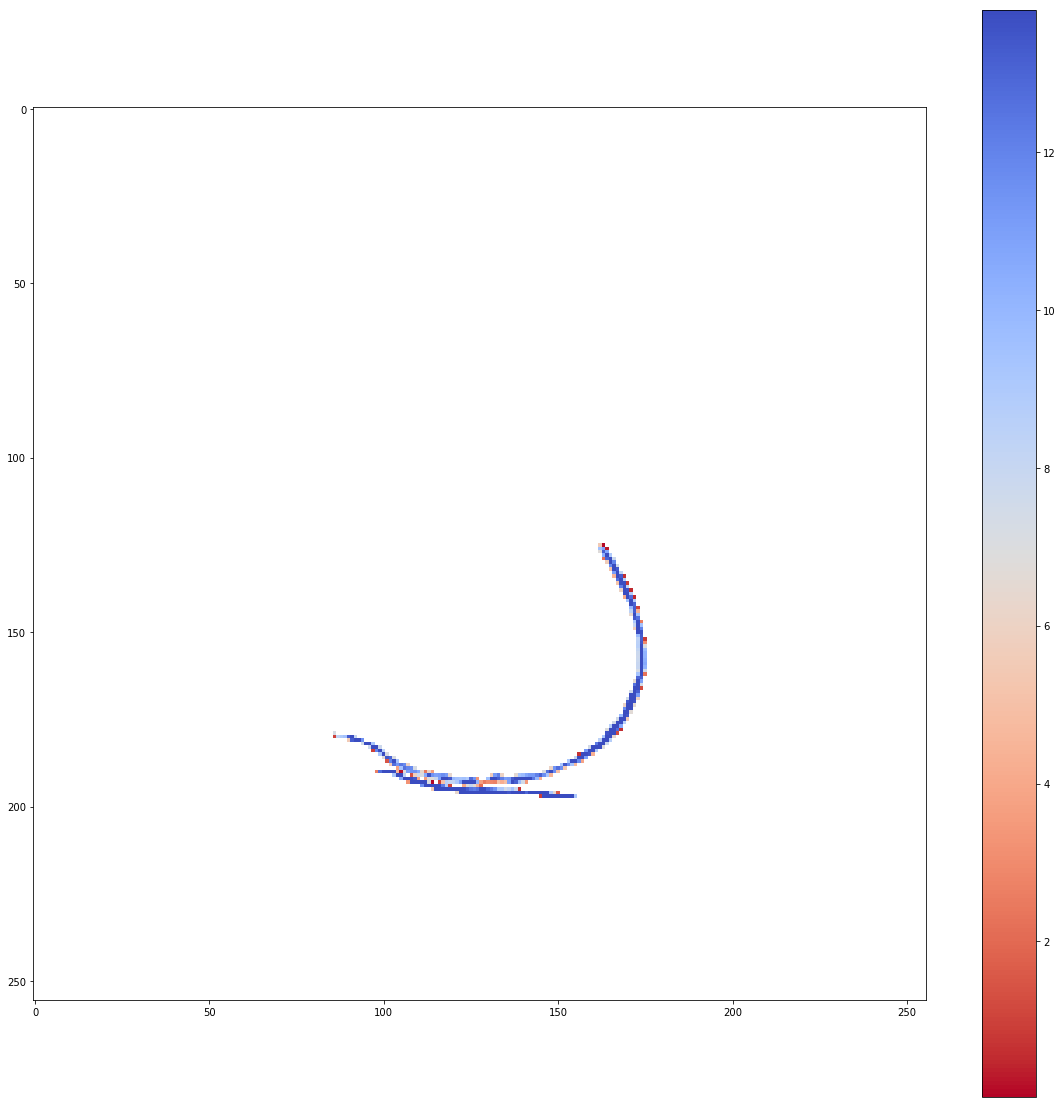

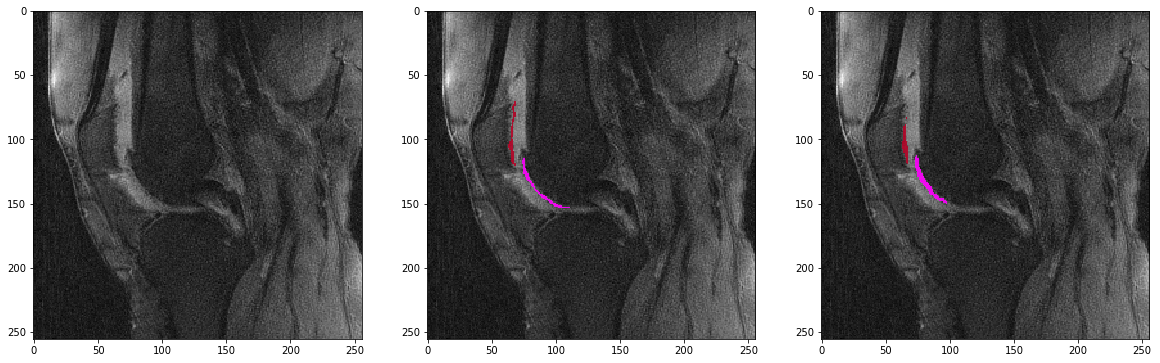

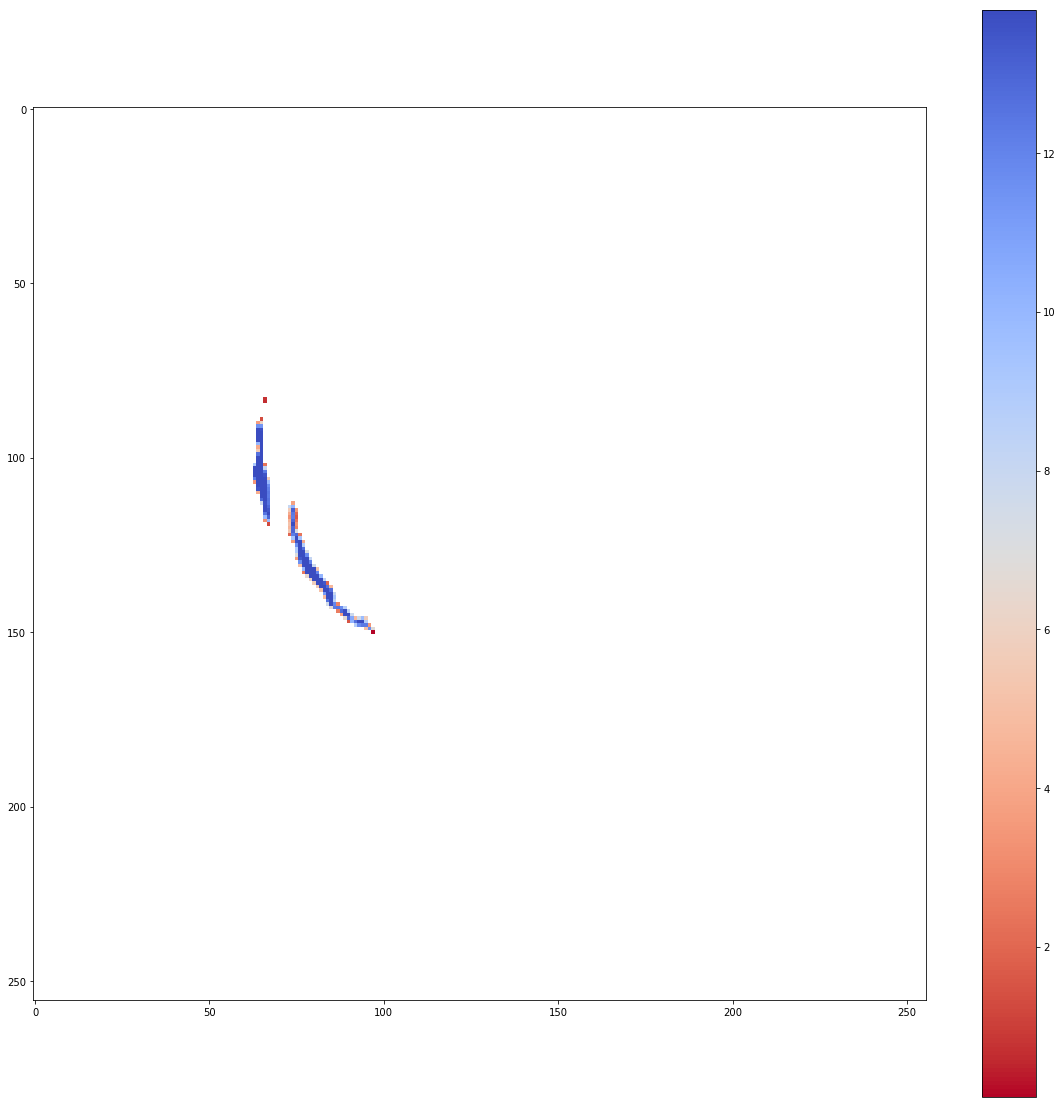

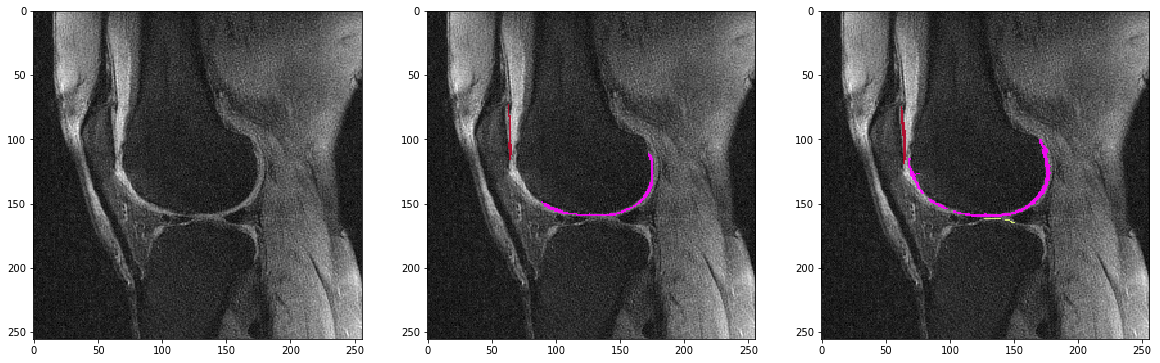

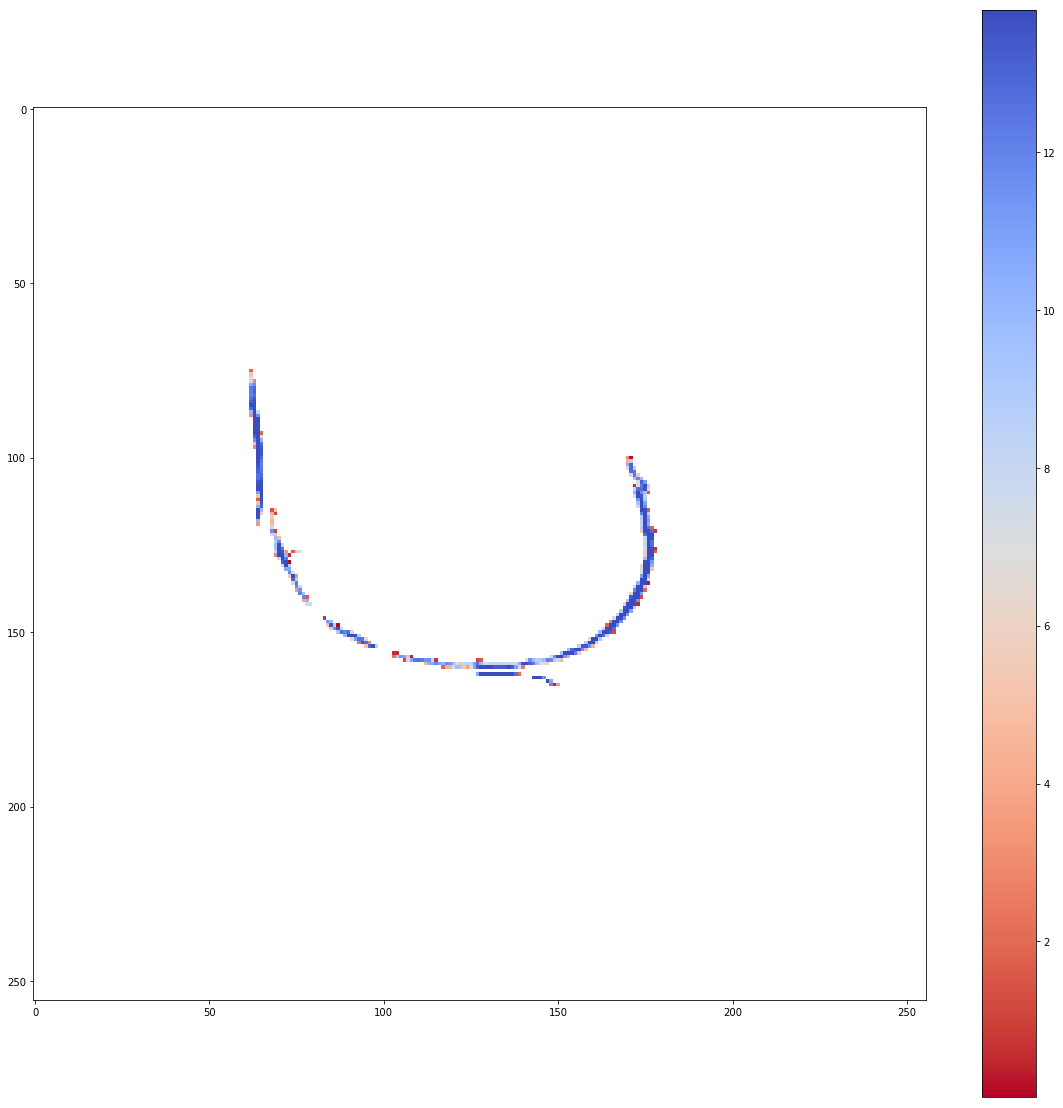

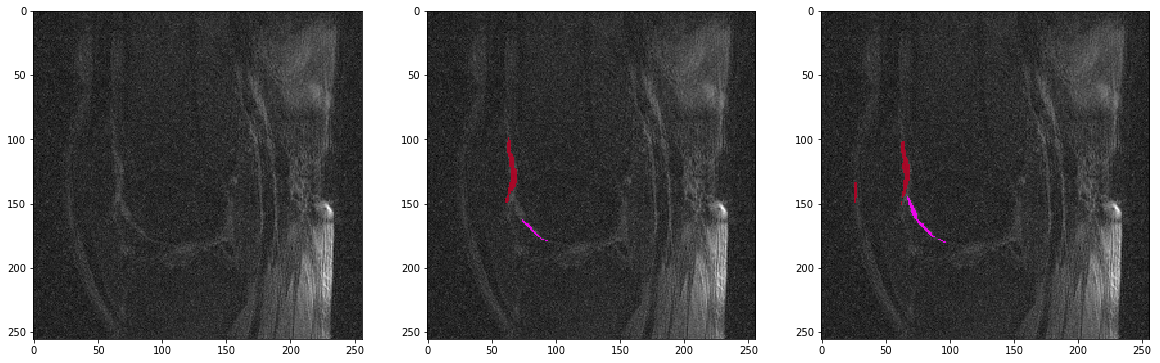

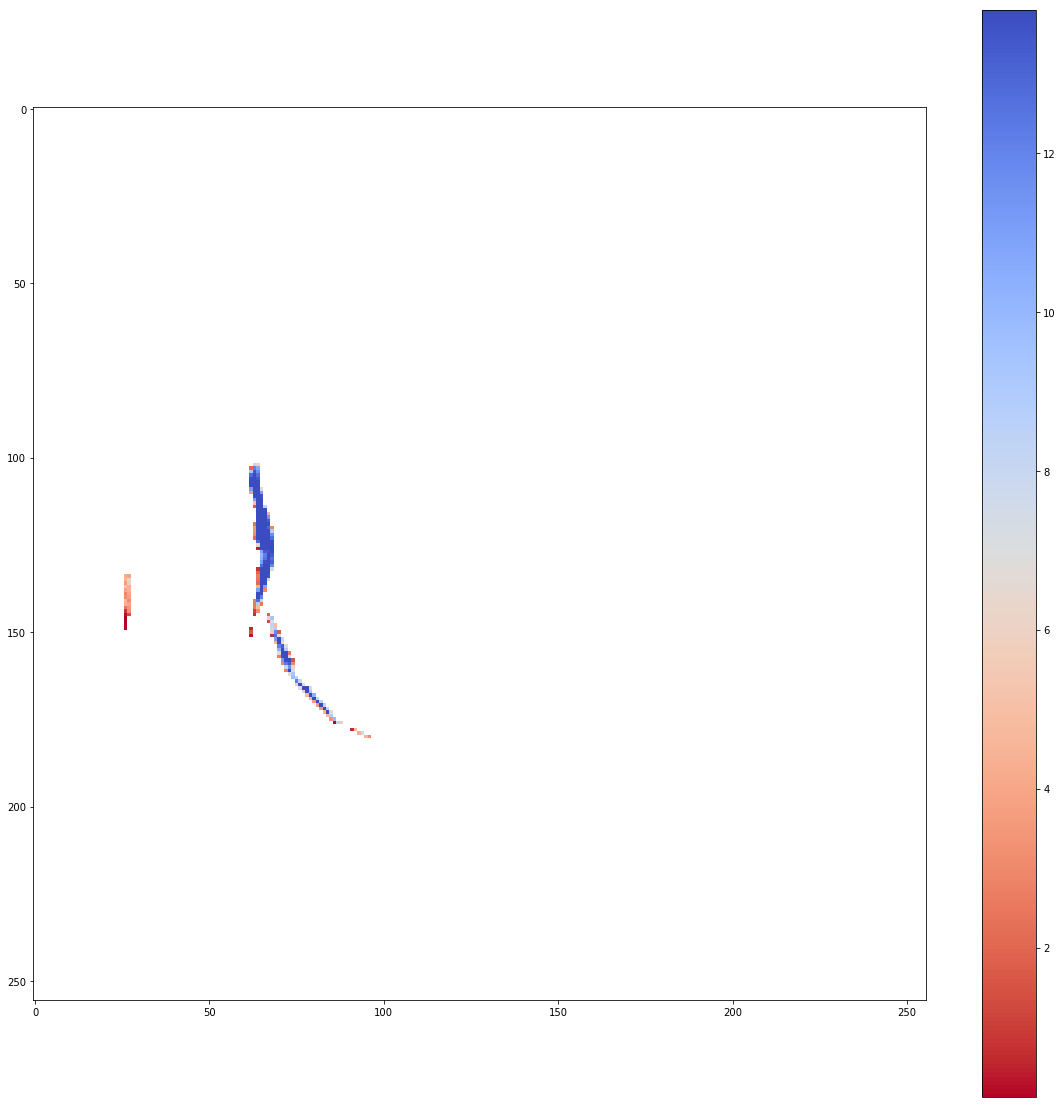

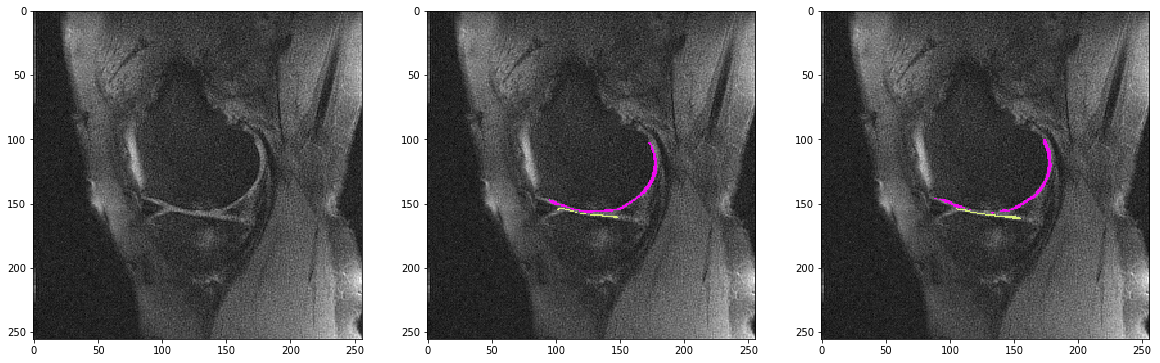

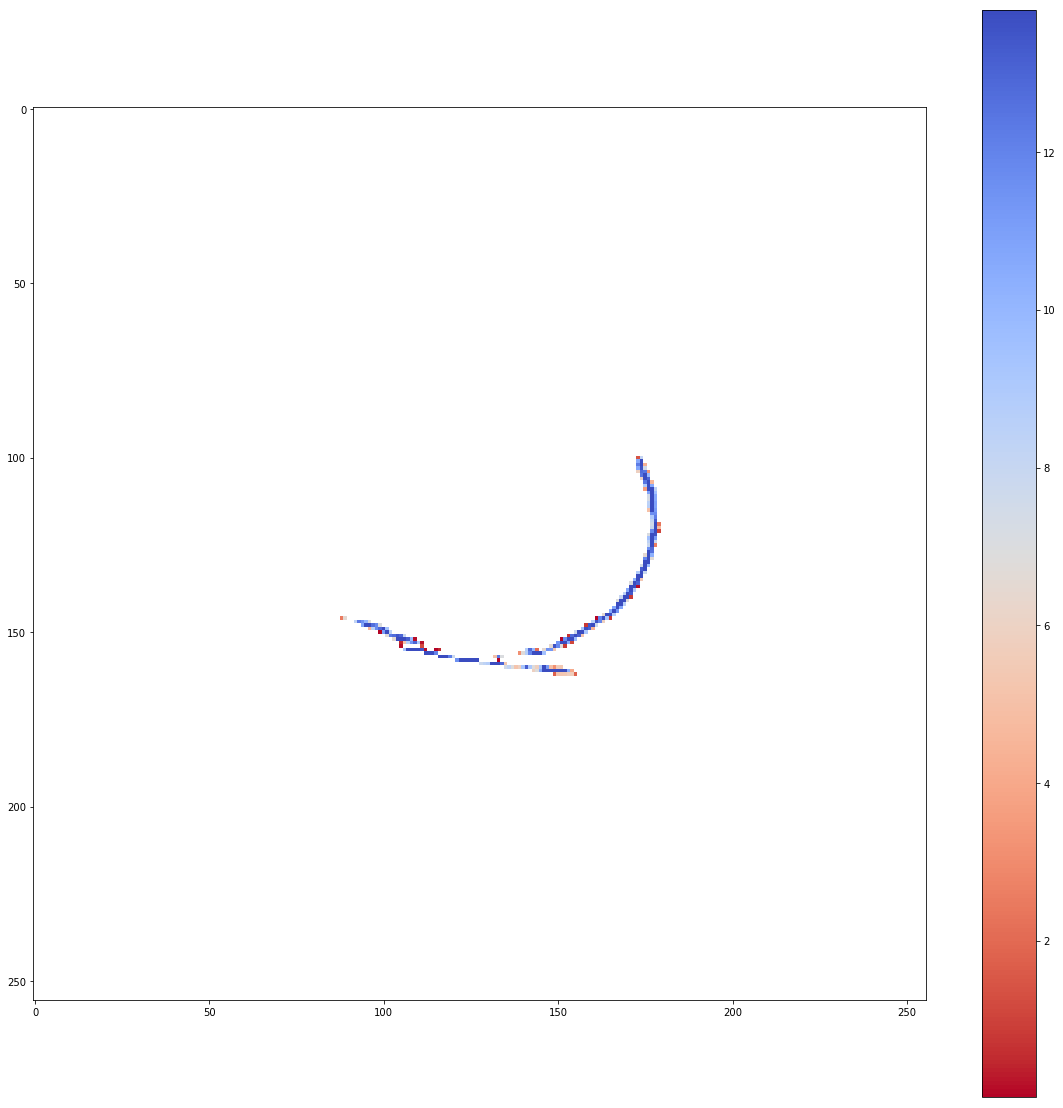

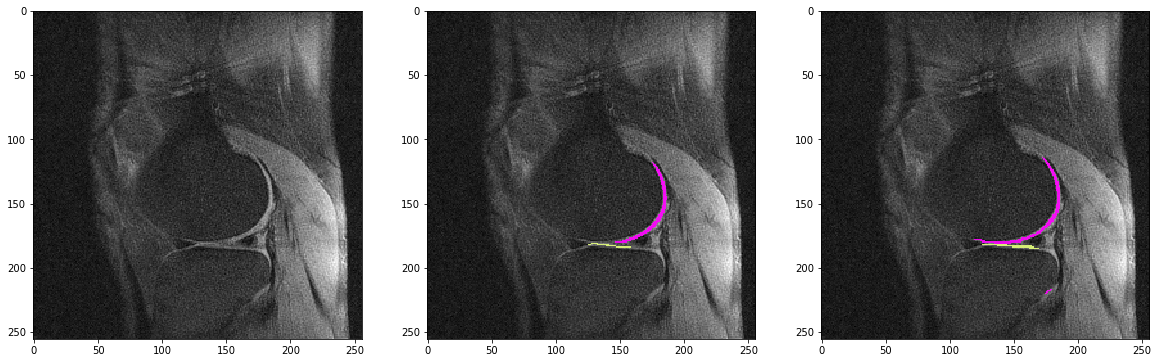

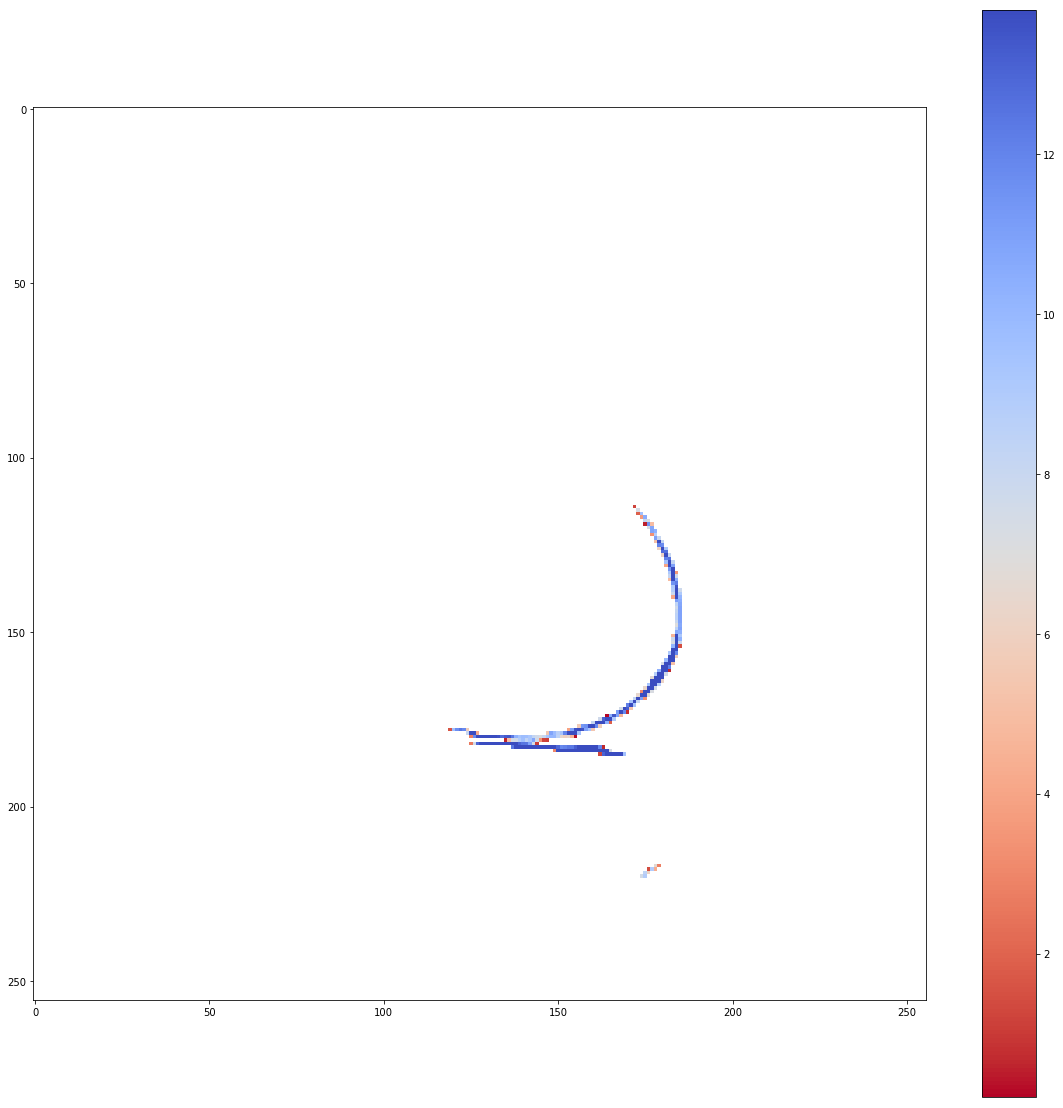

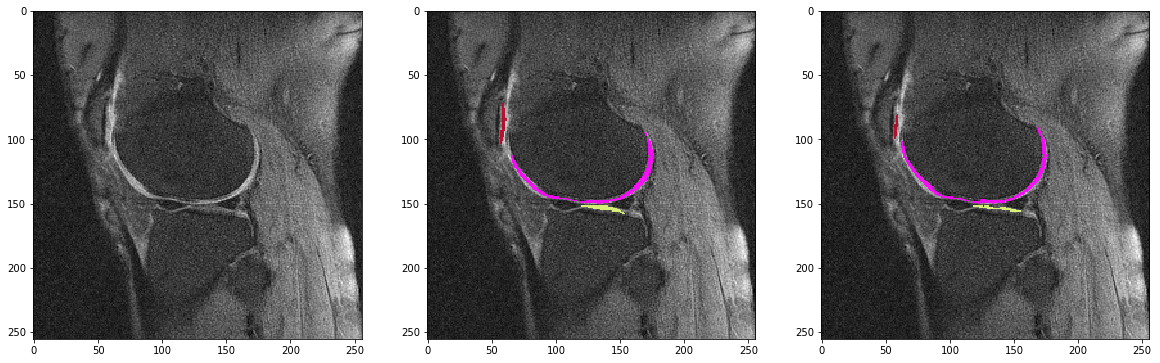

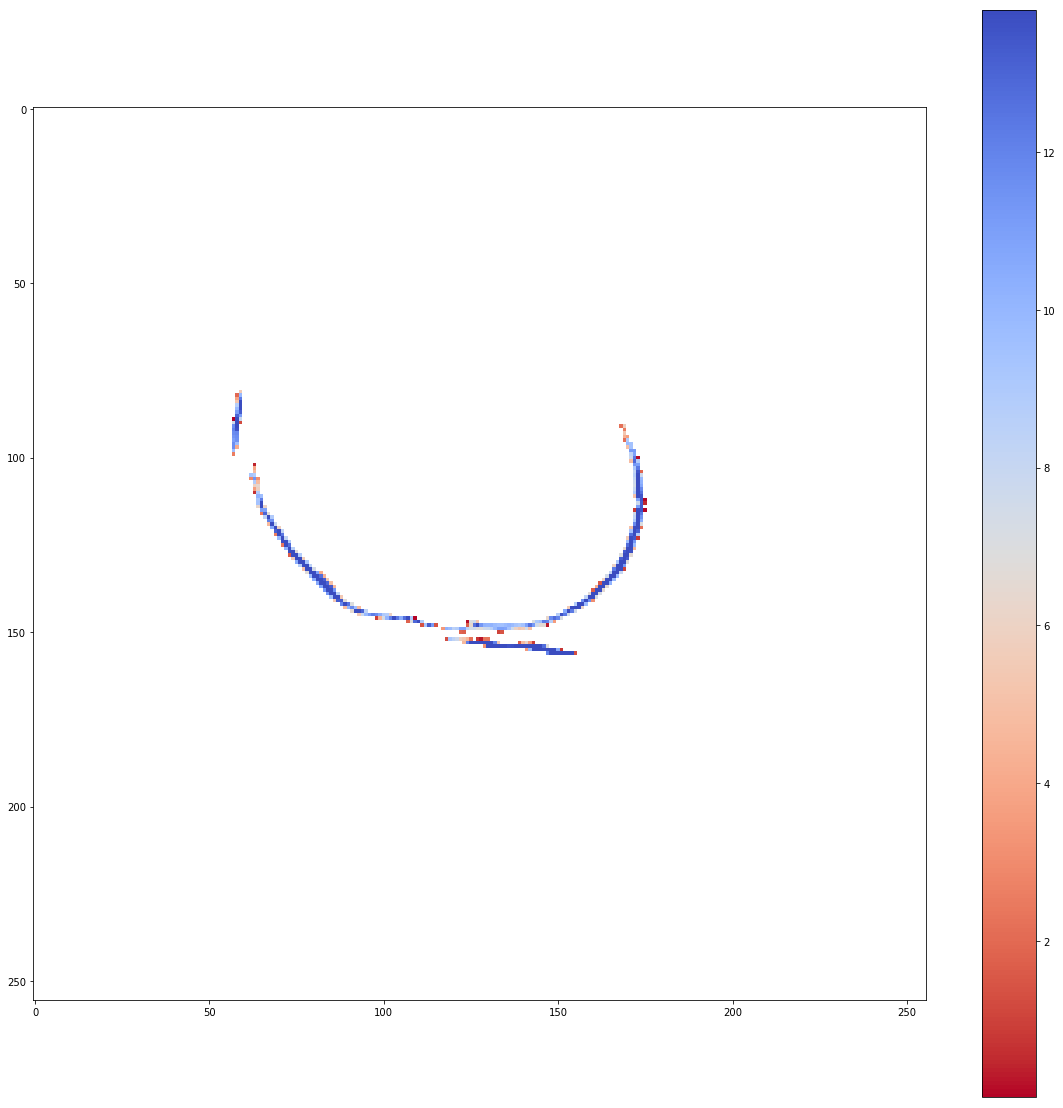

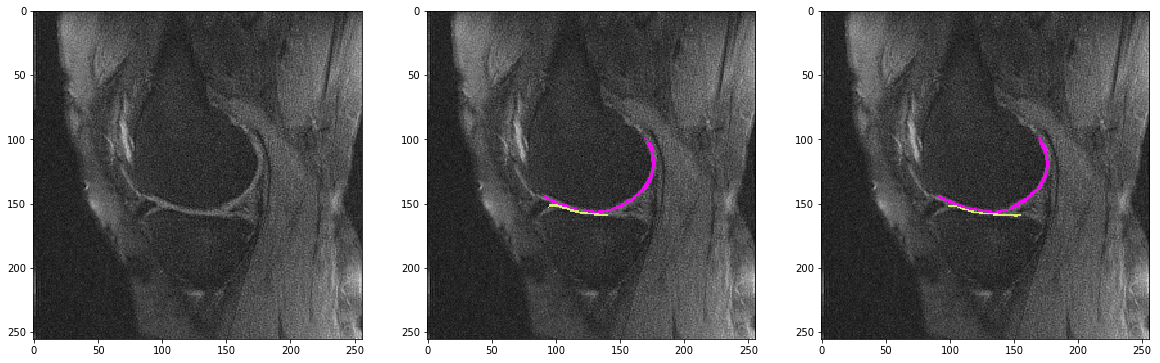

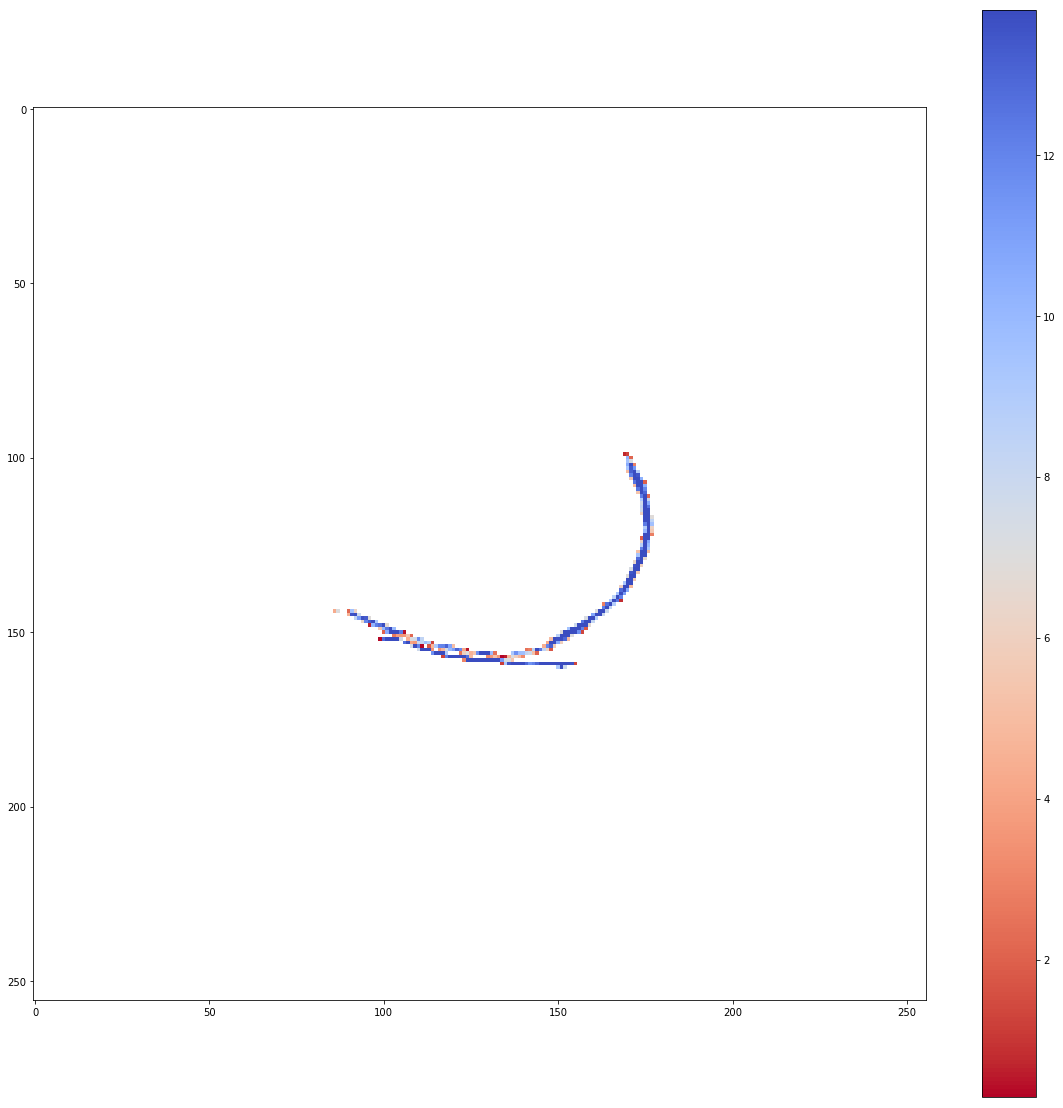

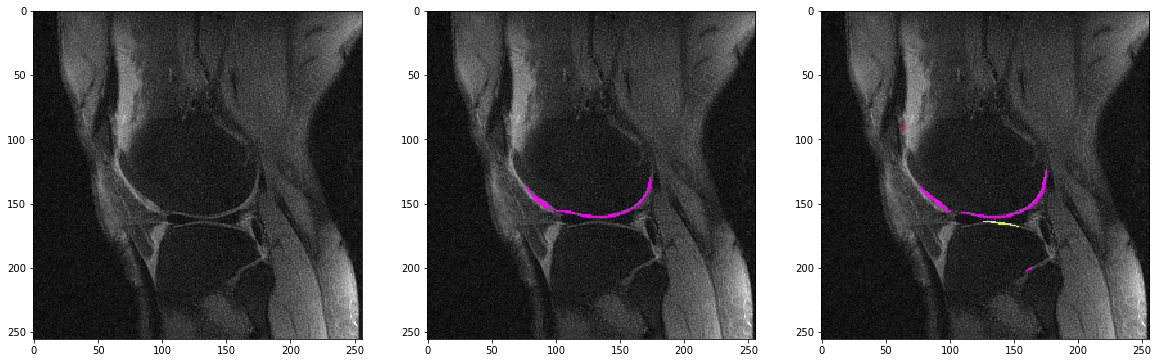

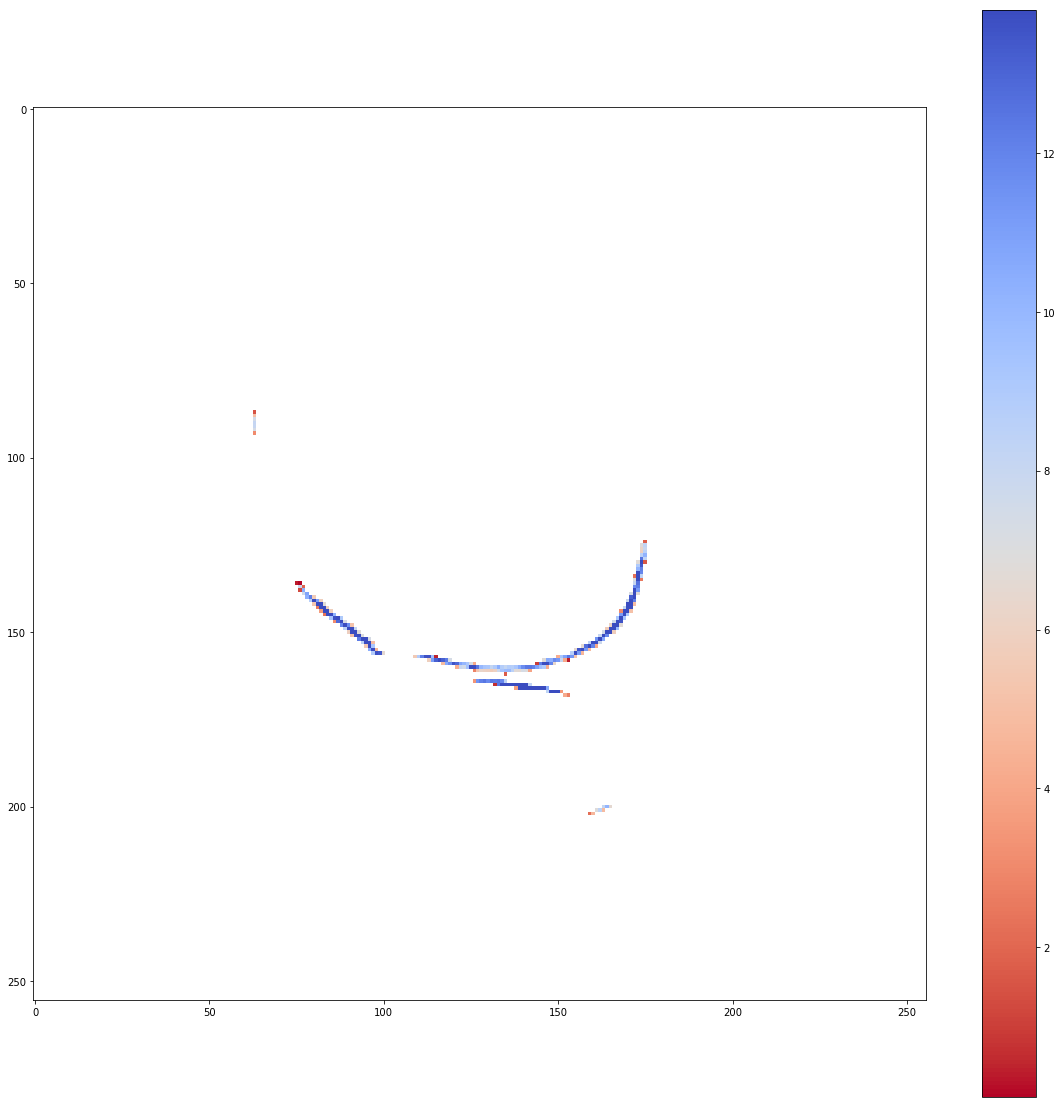

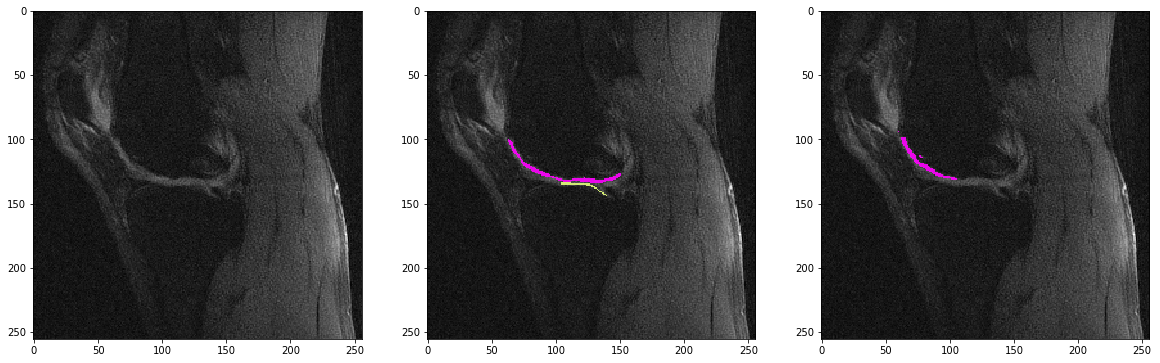

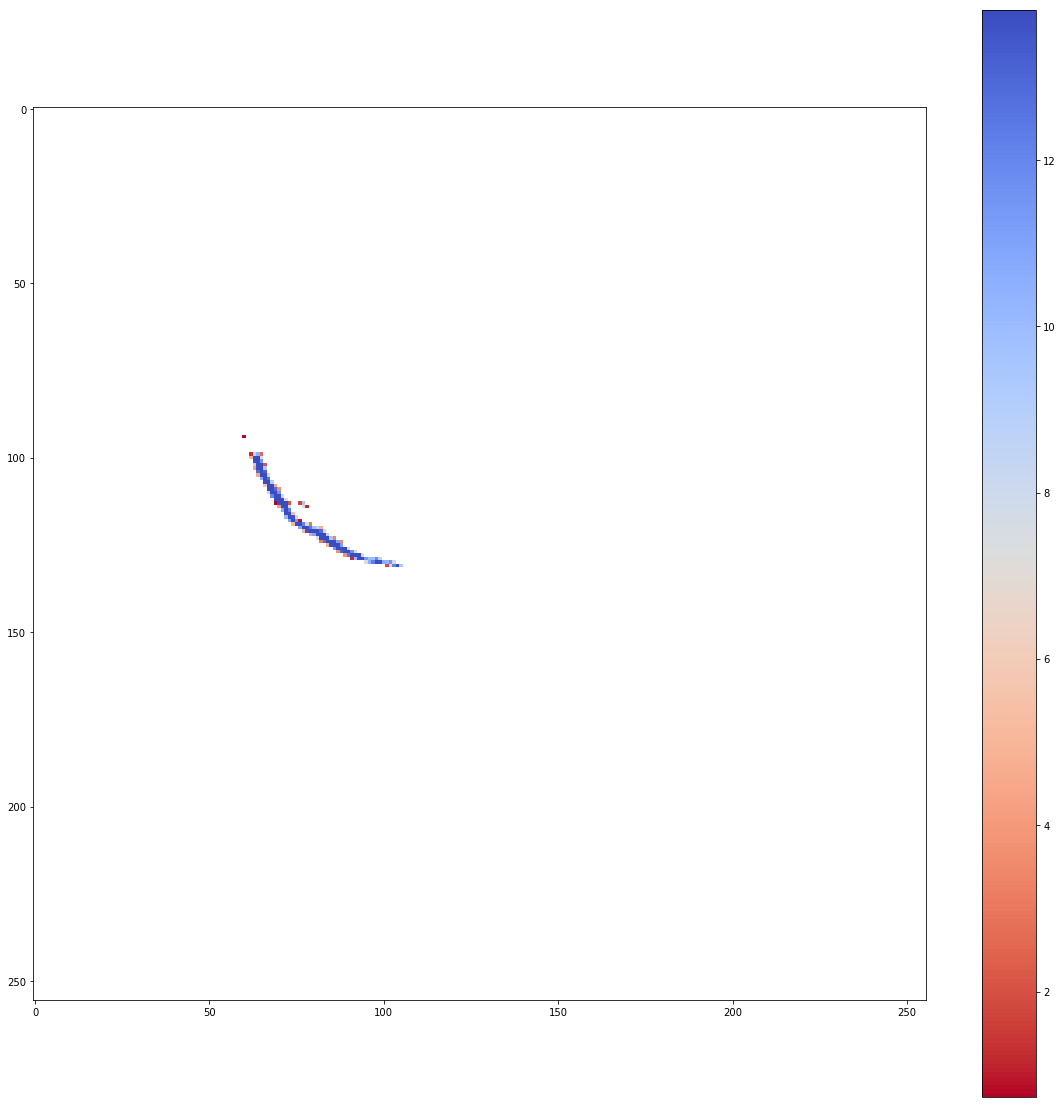

validate loss: 0.4196, Dice Score (class 0): 0.6887, Dice Score (class 1): 0.7832,Dice Score (class 2): 0.6403


In [260]:
_,_,_,_,dice_hist_smooth, acc_hist = evaluate_pp(loaded_model,pred_models, dataloader, data_sizes, 5, 'validate', \
                                          dice_loss=dice_loss_3,smooth =False, certainity_map = True)

# Discussion
1. As it can be seen above that the validation score improved from 0.43 to 0.41 by ensembling the models. The dice scores for each class (tissue) also improved. Class 0: 0.671 to 0.688, class 1: 0.77 to 0.783 and class 2: 0.62 to 0.64
2. We also incorporated the confidence maps in the prediction that can help the doctors to see the confidence of the model's prediction and make a decision. (more red the pixel value, less confident the model is about the prediction)
3. This was the best model that was compared with the human expert level performance which is discussed below.


# Evaluation of best model on test set

True Map


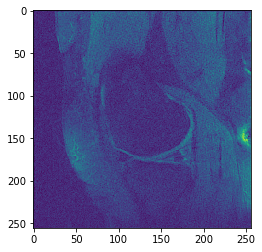

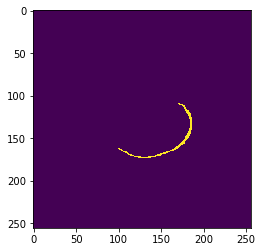

Predicted Map


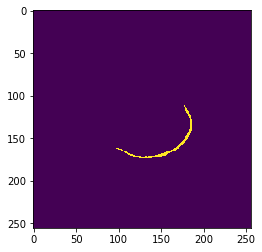

True Map


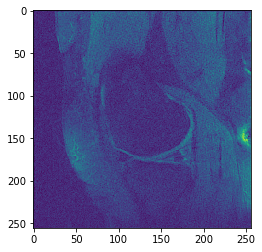

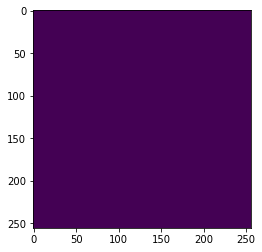

Predicted Map


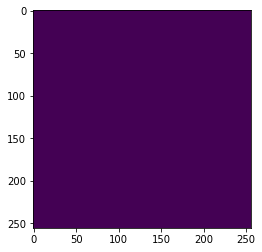

True Map


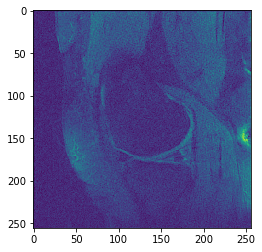

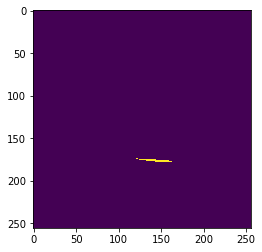

Predicted Map


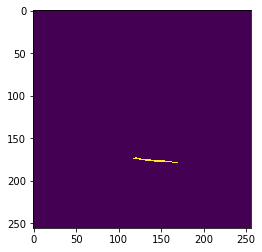

True Map


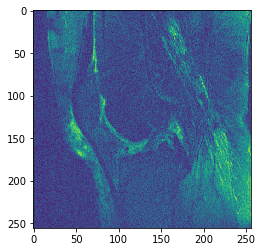

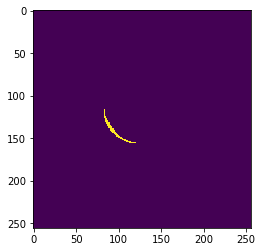

Predicted Map


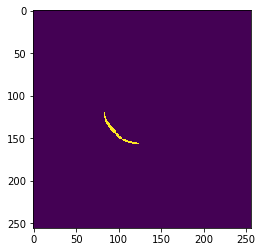

True Map


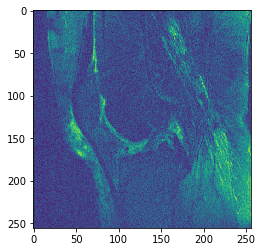

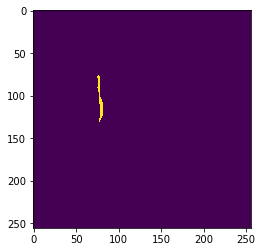

Predicted Map


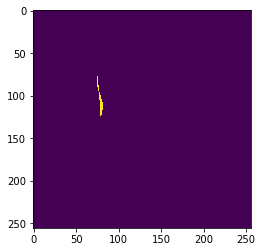

True Map


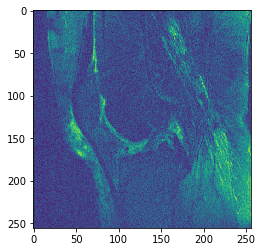

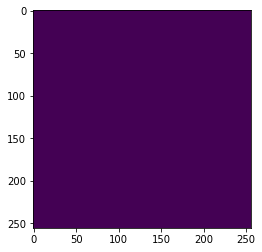

Predicted Map


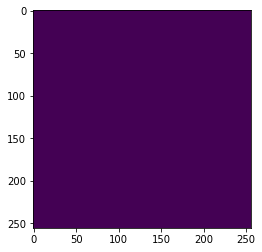

True Map


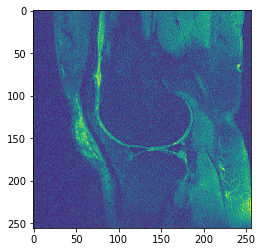

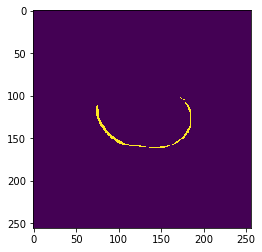

Predicted Map


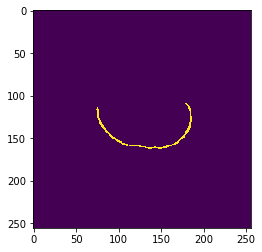

True Map


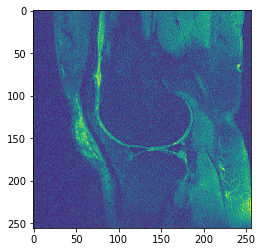

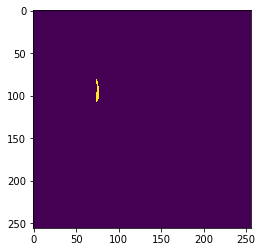

Predicted Map


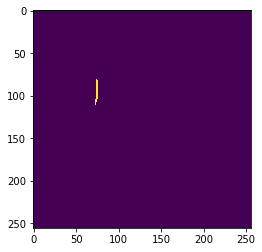

True Map


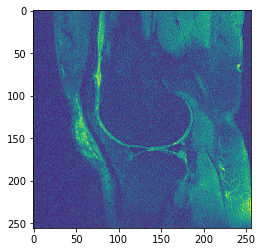

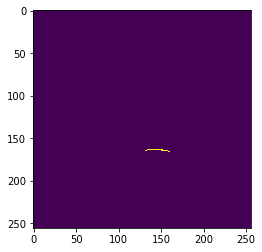

Predicted Map


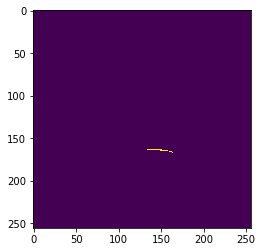

True Map


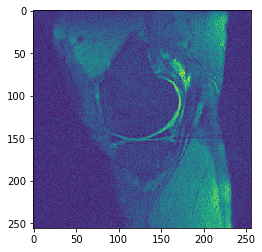

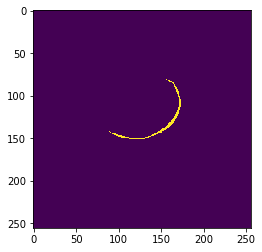

Predicted Map


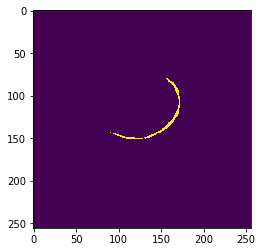

True Map


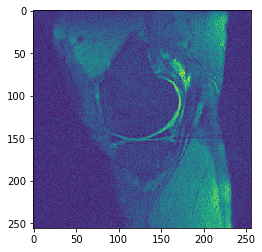

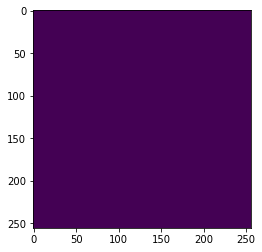

Predicted Map


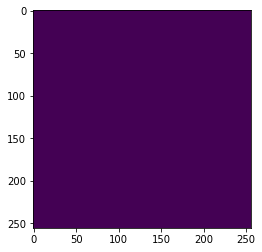

True Map


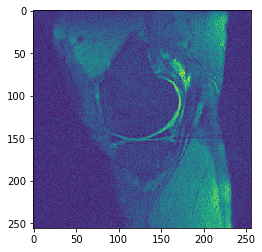

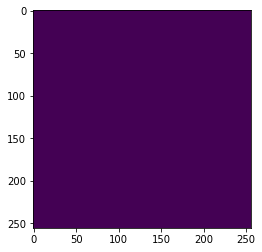

Predicted Map


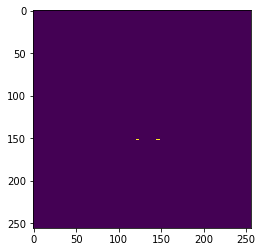

True Map


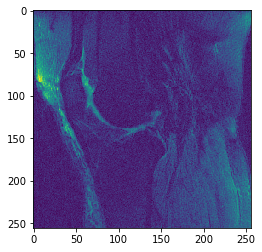

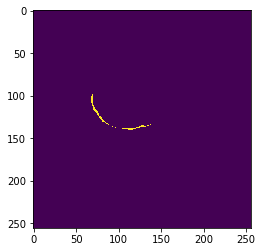

Predicted Map


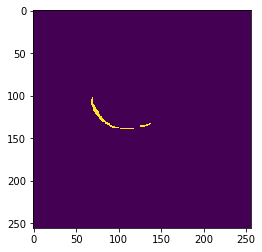

True Map


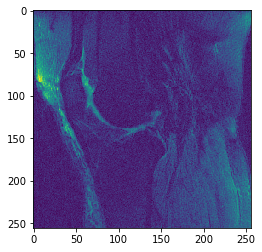

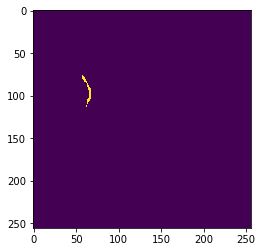

Predicted Map


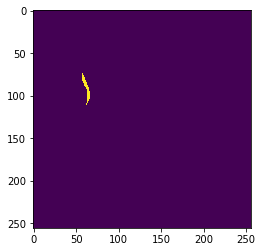

True Map


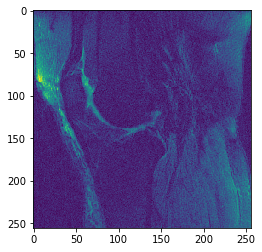

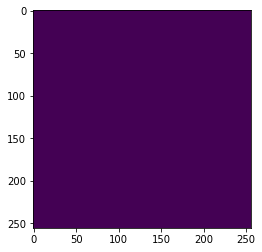

Predicted Map


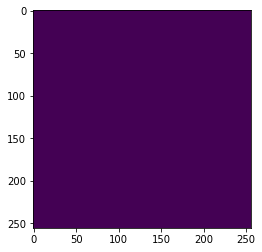

True Map


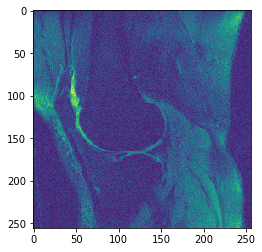

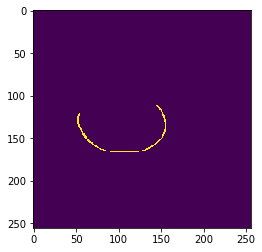

Predicted Map


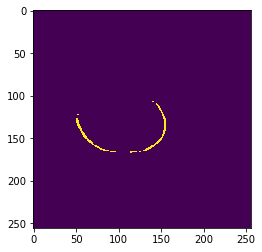

True Map


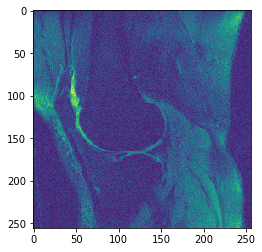

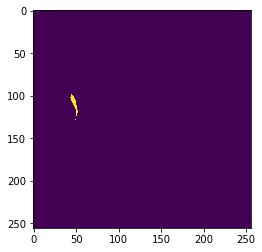

Predicted Map


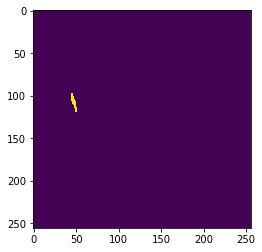

True Map


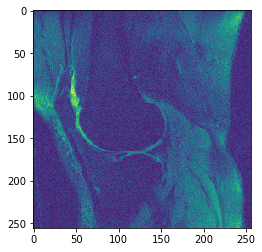

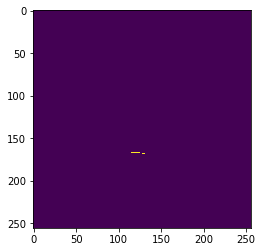

Predicted Map


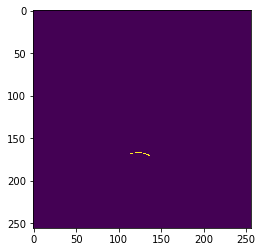

True Map


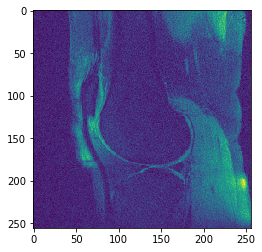

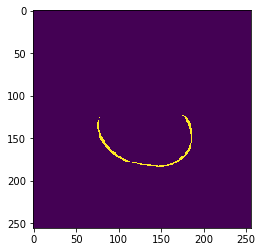

Predicted Map


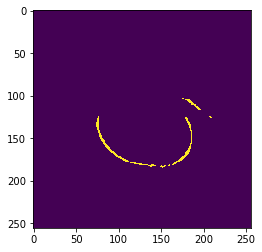

True Map


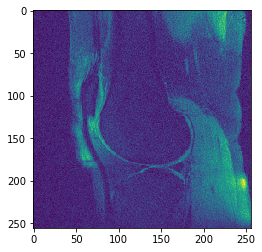

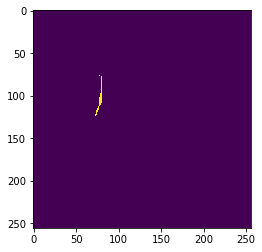

Predicted Map


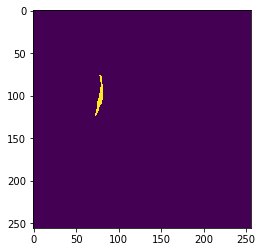

True Map


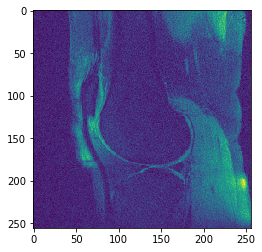

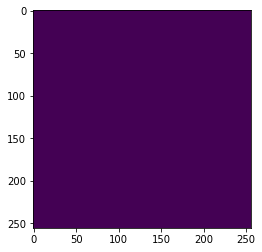

Predicted Map


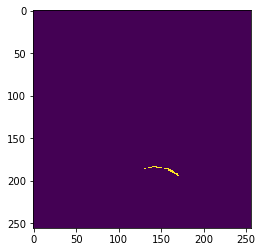

True Map


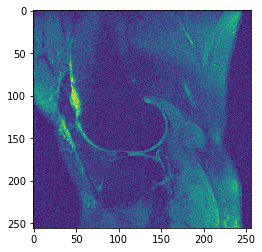

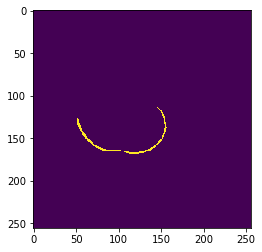

Predicted Map


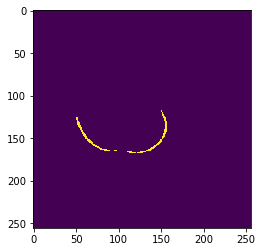

True Map


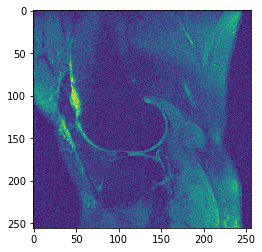

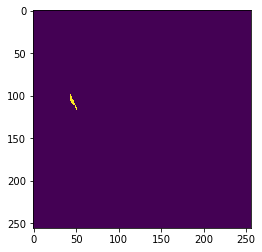

Predicted Map


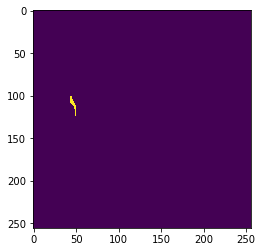

True Map


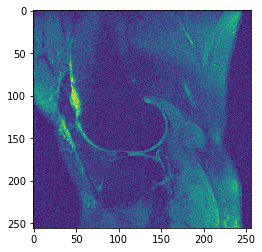

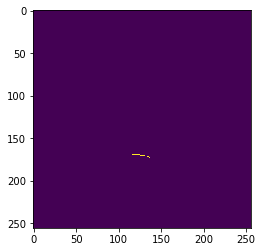

Predicted Map


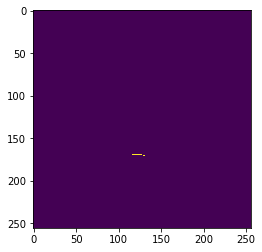

True Map


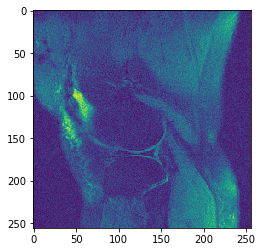

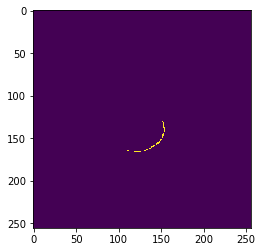

Predicted Map


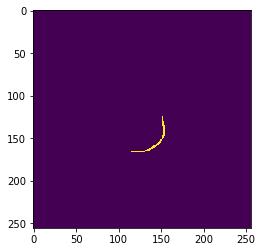

True Map


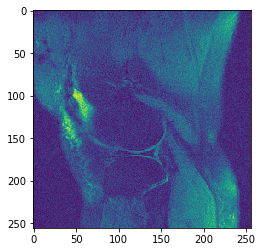

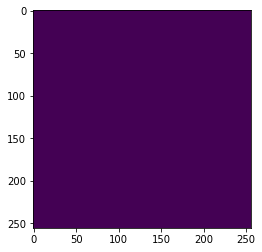

Predicted Map


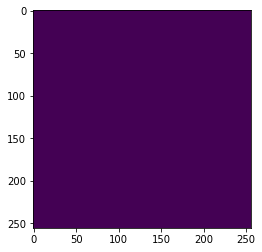

True Map


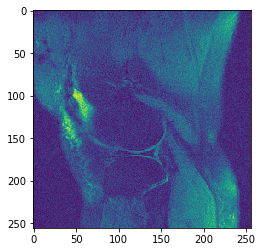

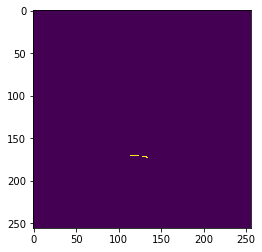

Predicted Map


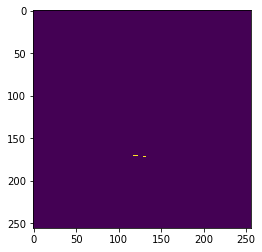

True Map


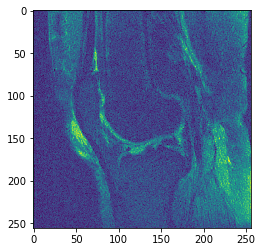

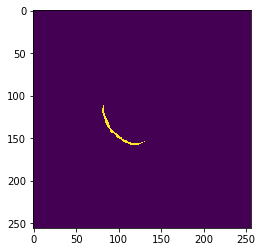

Predicted Map


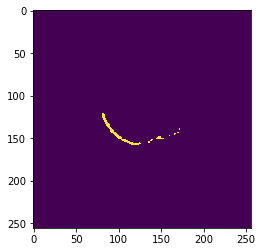

True Map


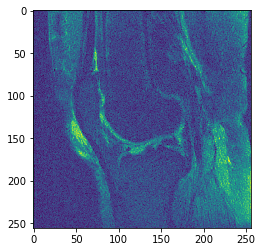

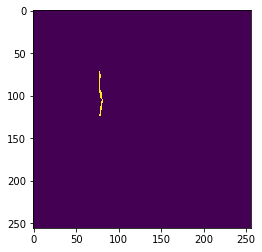

Predicted Map


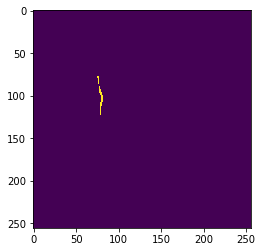

True Map


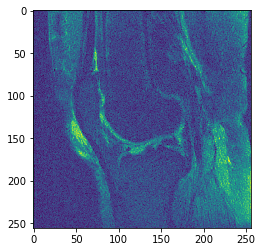

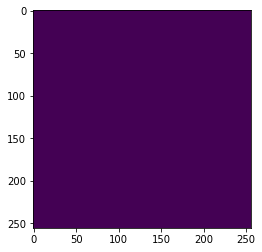

Predicted Map


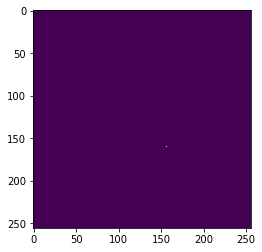

test loss: 0.4061, Dice Score (class 0): 0.6902, Dice Score (class 1): 0.7789,Dice Score (class 2): 0.6814


In [52]:
_,_,_,_,dice_hist_smooth, acc_hist = evaluate_pp(loaded_model,pred_models, dataloader, data_sizes, 5, 'test', \
                                          dice_loss=dice_loss_3,smooth = False)

# Discussion
The best model is evaluated on the test set. It is seen that it generalizes very-well on the unseen data giving much better test loss and test dice scores.